In [ ]:
# !pip install -U datasets transformers accelerate evaluate scikit-learn

In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

ds = load_dataset("cardiffnlp/tweet_eval", "sentiment")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

sentiment/train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

sentiment/test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

sentiment/validation-00000-of-00001.parq(…):   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
df = pd.DataFrame(ds['train'])
df.head()

,text,label
0,"""QT @user In the original draft of the 7th boo...",2
1,"""Ben Smith / Smith (concussion) remains out of...",1
2,Sorry bout the stream last night I crashed out...,1
3,Chase Headley's RBI double in the 8th inning o...,1
4,@user Alciato: Bee will invest 150 million in ...,2


## Dataset Analysis Notebook code (EDA)

In [ ]:
# Imports
from datasets import load_dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
import evaluate
from sklearn.metrics import classification_report

import torch

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [ ]:
# Load dataset
ds = load_dataset("cardiffnlp/tweet_eval", "sentiment")

train_ds = ds["train"]
val_ds = ds["validation"]
test_ds = ds["test"]

train_df = pd.DataFrame(train_ds)
val_df = pd.DataFrame(val_ds)
test_df = pd.DataFrame(test_ds)

label_map = {0: "negative", 1: "neutral", 2: "positive"}
id2label = {i: label_map[i] for i in label_map}
label2id = {v: k for k, v in label_map.items()}


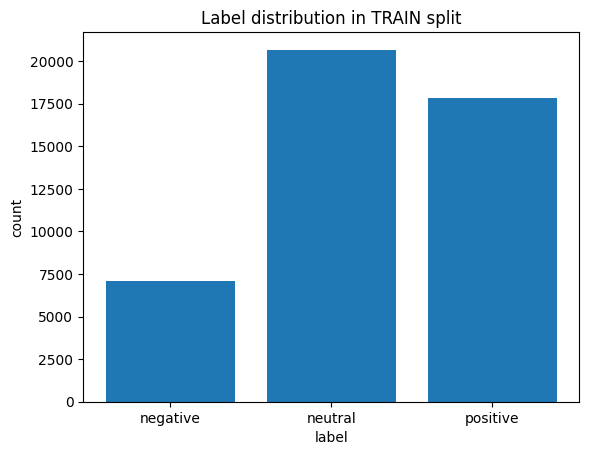

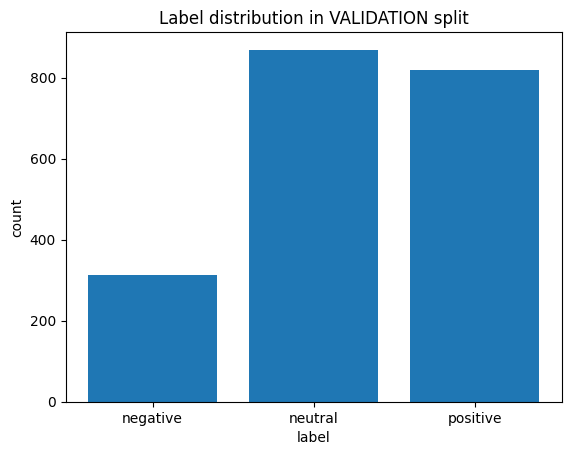

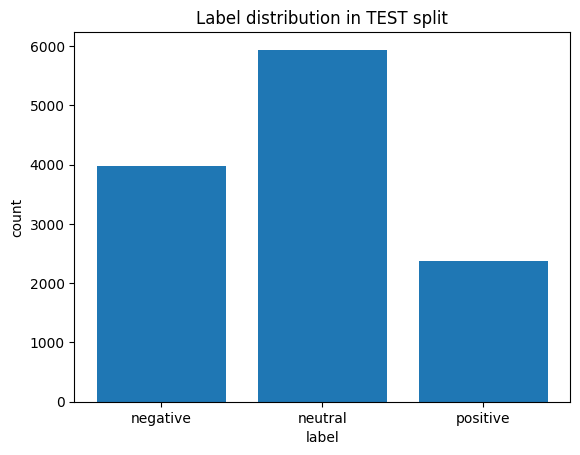

In [ ]:
# EDA: label
def plot_label_distribution(df, title):
    counts = df["label"].value_counts().sort_index()
    labels = [label_map[i] for i in counts.index]

    plt.figure()
    plt.bar(labels, counts.values)
    plt.title(title)
    plt.xlabel("label")
    plt.ylabel("count")
    plt.show()

plot_label_distribution(train_df, "Label distribution in TRAIN split")
plot_label_distribution(val_df, "Label distribution in VALIDATION split")
plot_label_distribution(test_df, "Label distribution in TEST split")

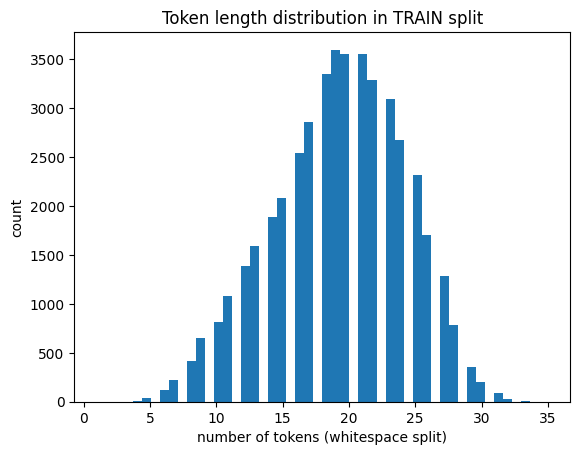


Train token length stats:
count    45615.000000
mean        19.237444
std          4.935990
min          1.000000
25%         16.000000
50%         20.000000
75%         23.000000
max         35.000000
Name: train_token_len, dtype: float64


In [ ]:
# EDA: token length
for name, df in [("train", train_df), ("validation", val_df), ("test", test_df)]:
    df[f"{name}_token_len"] = df["text"].apply(lambda x: len(str(x).split()))

plt.figure()
plt.hist(train_df["train_token_len"], bins=50)
plt.title("Token length distribution in TRAIN split")
plt.xlabel("number of tokens (whitespace split)")
plt.ylabel("count")
plt.show()

print("\nTrain token length stats:")
print(train_df["train_token_len"].describe())

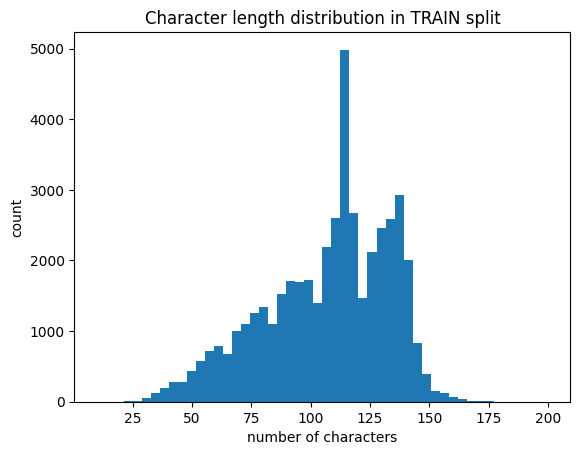


Character length statistics:
count    45615.000000
mean       106.932851
std         26.251517
min         10.000000
25%         89.000000
50%        113.000000
75%        128.000000
max        200.000000
Name: char_len, dtype: float64


In [ ]:
#  EDA: character length
train_df["char_len"] = train_df["text"].apply(lambda x: len(str(x)))

plt.figure()
plt.hist(train_df["char_len"], bins=50)
plt.title("Character length distribution in TRAIN split")
plt.xlabel("number of characters")
plt.ylabel("count")
plt.show()

print("\nCharacter length statistics:")
print(train_df["char_len"].describe())

In [ ]:
# Data cleaning
def basic_clean(text: str) -> str:
    # keep @user and emoji
    text = str(text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

train_df["clean_text"] = train_df["text"].apply(basic_clean)

print("\n===== Before/After cleaning (first 3 samples) =====")
for i in range(3):
    print(f"\n--- Sample {i} ---")
    print("Original:", train_df.loc[i, "text"])
    print("Cleaned :", train_df.loc[i, "clean_text"])

# show random label
def show_random_examples(df, n_per_label=3, random_state=42):
    random.seed(random_state)
    for label_id, label_name in label_map.items():
        subset = df[df["label"] == label_id]
        print(f"\n===== Label {label_id} ({label_name}) examples =====")
        samples = subset.sample(
            n=min(n_per_label, len(subset)),
            random_state=random_state
        )
        for text in samples["text"].tolist():
            print("-", text)

print("\nRandom examples from the TRAIN split:")
show_random_examples(train_df, n_per_label=4, random_state=42)


===== Before/After cleaning (first 3 samples) =====

--- Sample 0 ---
Original: "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"
Cleaned : "QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"

--- Sample 1 ---
Original: "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"
Cleaned : "Ben Smith / Smith (concussion) remains out of the lineup Thursday, Curtis #NHL #SJ"

--- Sample 2 ---
Original: Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.
Cleaned : Sorry bout the stream last night I crashed out but will be on tonight for sure. Then back to Minecraft in pc tomorrow night.

Random examples from the TRAIN split:

===== Label 0 (negative) examples =====
- "#CNET - Just bought my 1st iPad, iPad3, feeling real burned, mad, about iPad4 so soon. Grr

##Baseline BERT

In [ ]:
import os
os.environ["WANDB_PROJECT"] = "tweet-eval-sentiment"
os.environ["WANDB_WATCH"] = "false"

In [ ]:
# import os
# os.environ["WANDB_DISABLED"] = "true"   # disable wandb so it won't ask for API key

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report
import random

# set random seeds for reproducibility
random.seed(42)
np.random.seed(42)

# 1. Load TweetEval sentiment dataset

ds = load_dataset("cardiffnlp/tweet_eval", "sentiment")

train_ds = ds["train"]
val_ds = ds["validation"]
test_ds = ds["test"]

label_map = {0: "negative", 1: "neutral", 2: "positive"}
id2label = {i: label_map[i] for i in label_map}
label2id = {v: k for k, v in label_map.items()}

print(train_ds)
print(val_ds)
print(test_ds)

# 2. Tokenizer and preprocessing
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess_function(examples):
    # if you want to use cleaned text later, replace "examples['text']"
    # with "examples['clean_text']" after you add that column
    return tokenizer(
        examples["text"],
        truncation=True,
        padding=False,      # padding will be handled by data collator
        max_length=128,
    )

encoded_ds = ds.map(preprocess_function, batched=True)

# remove original text column so Trainer sees only tensors + labels
encoded_ds = encoded_ds.remove_columns(["text"])
encoded_ds = encoded_ds.rename_column("label", "labels")
encoded_ds.set_format("torch")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# 3. Metric function (accuracy + macro-F1)
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    macro_f1 = f1_score(labels, preds, average="macro")

    return {"accuracy": acc, "macro_f1": macro_f1}

Dataset({
    features: ['text', 'label'],
    num_rows: 45615
})
Dataset({
    features: ['text', 'label'],
    num_rows: 2000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 12284
})


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
#  4. Load BERT model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

# 5. Training arguments
training_args = TrainingArguments(
    output_dir="./bert-sentiment",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
)


# 6. Build Trainer and train baseline BERT
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

train_result = trainer.train()
print("\nTraining finished.")

#  7. Evaluation on validation and test sets
print("\n=== Validation set results (BERT baseline) ===")
val_results = trainer.evaluate(encoded_ds["validation"])
for k, v in val_results.items():
    print(f"{k}: {v:.4f}")

print("\n=== Test set results (BERT baseline) ===")
test_results = trainer.evaluate(encoded_ds["test"])
for k, v in test_results.items():
    print(f"{k}: {v:.4f}")

# 8. Detailed classification report on test set
pred_output = trainer.predict(encoded_ds["test"])
test_logits = pred_output.predictions
test_labels = pred_output.label_ids
test_preds = np.argmax(test_logits, axis=-1)

print("\n=== Classification report on TEST set (BERT baseline) ===")
print(
    classification_report(
        test_labels,
        test_preds,
        target_names=[label_map[i] for i in sorted(label_map.keys())]
    )
)

# 9. Show some random qualitative examples
raw_test = ds["test"]

indices = random.sample(range(len(raw_test)), 5)

for idx in indices:
    text = raw_test[idx]["text"]
    true_label = label_map[raw_test[idx]["label"]]
    pred_label = label_map[int(test_preds[idx])]
    print("\nTweet:", text)
    print("True label :", true_label)
    print("Pred label :", pred_label)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-4214588544.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.657400,0.599794,0.736500,0.721527
2,0.485000,0.610274,0.757500,0.735855
3,0.357900,0.691207,0.751500,0.736135



Training finished.

=== Validation set results (BERT baseline) ===


eval_loss: 0.6912
eval_accuracy: 0.7515
eval_macro_f1: 0.7361
eval_runtime: 2.6895
eval_samples_per_second: 743.6300
eval_steps_per_second: 11.8980
epoch: 3.0000

=== Test set results (BERT baseline) ===
eval_loss: 0.8008
eval_accuracy: 0.6915
eval_macro_f1: 0.6908
eval_runtime: 14.5195
eval_samples_per_second: 846.0330
eval_steps_per_second: 13.2240
epoch: 3.0000

=== Classification report on TEST set (BERT baseline) ===
              precision    recall  f1-score   support

    negative       0.71      0.72      0.71      3972
     neutral       0.71      0.66      0.68      5937
    positive       0.62      0.74      0.68      2375

    accuracy                           0.69     12284
   macro avg       0.68      0.70      0.69     12284
weighted avg       0.69      0.69      0.69     12284


Tweet: when you jacked into your house without keys. hell yeah, i'm david blaine jr.
True label : positive
Pred label : positive

Tweet: Cigarettes and Valentines
True label : neutral
Pred lab

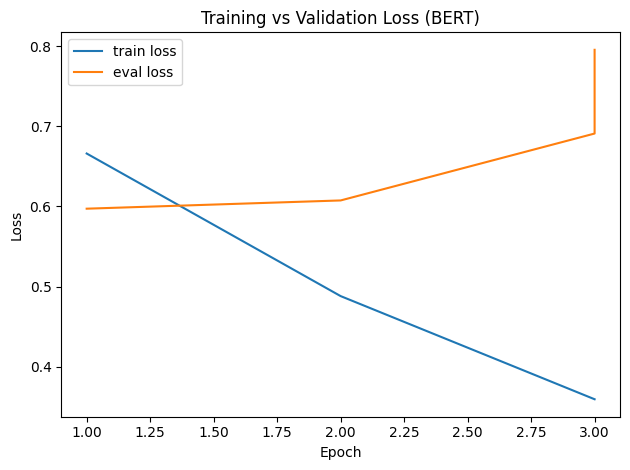

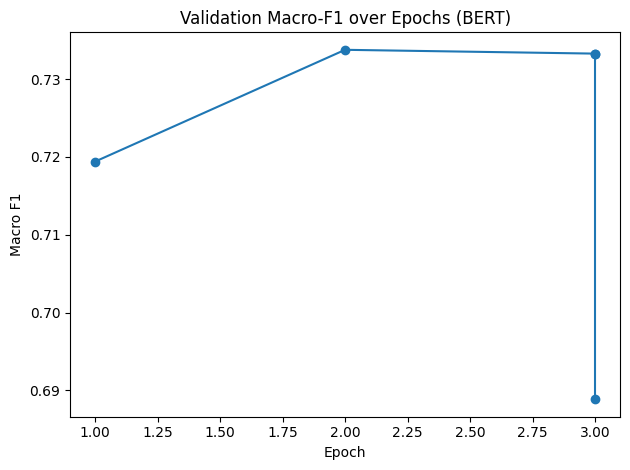

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)
print(df_logs.head())

# train loss
df_train = df_logs[df_logs["loss"].notnull()]

# test set: eval loss / accuracy / macro_f1
df_eval = df_logs[df_logs["eval_loss"].notnull()]

# Loss curve
plt.figure()
plt.plot(df_train["epoch"], df_train["loss"], label="train loss")
plt.plot(df_eval["epoch"], df_eval["eval_loss"], label="eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (BERT)")
plt.legend()
plt.tight_layout()
plt.show()

# Macro-F1 curve
if "eval_macro_f1" in df_eval.columns:
    plt.figure()
    plt.plot(df_eval["epoch"], df_eval["eval_macro_f1"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title("Validation Macro-F1 over Epochs (BERT)")
    plt.tight_layout()
    plt.show()


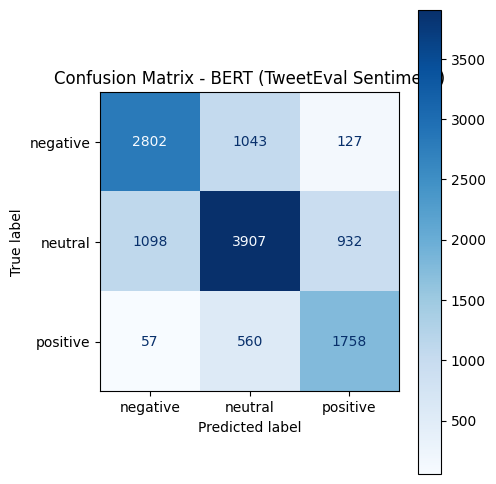

<Figure size 640x480 with 0 Axes>

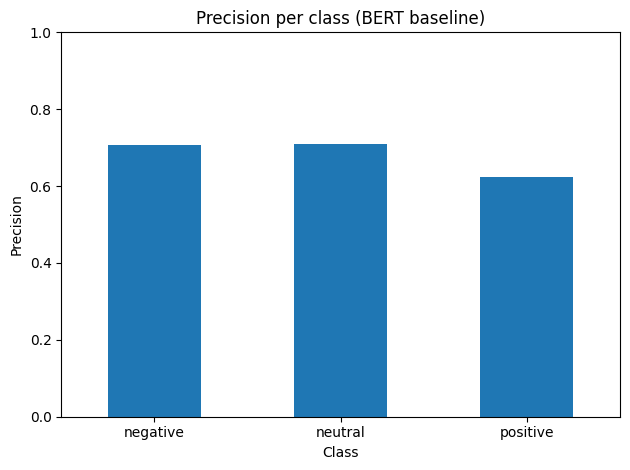

<Figure size 640x480 with 0 Axes>

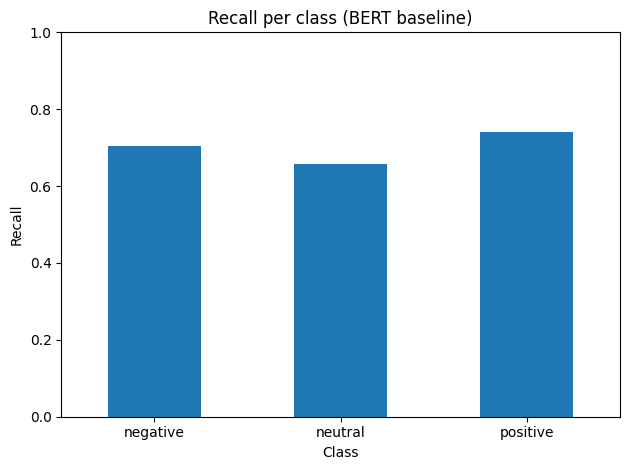

<Figure size 640x480 with 0 Axes>

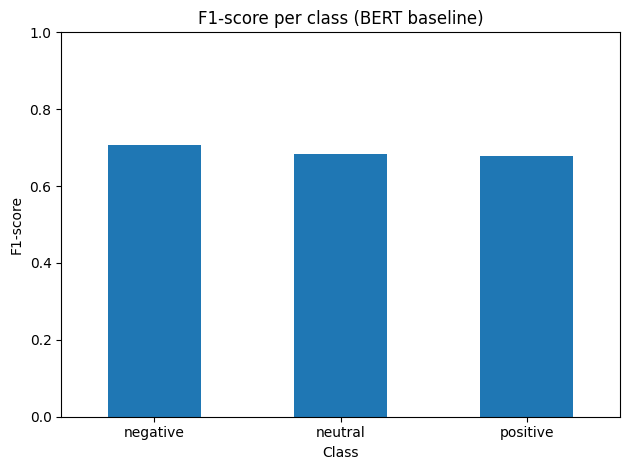

<Figure size 640x480 with 0 Axes>

In [ ]:
# Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd


# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[label_map[i] for i in sorted(label_map.keys())]
)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - BERT (TweetEval Sentiment)")
plt.tight_layout()
plt.show()


# Per-class Precision / Recall / F1 Bar Plots
report_dict = classification_report(
    test_labels,
    test_preds,
    target_names=[label_map[i] for i in sorted(label_map.keys())],
    output_dict=True,
)

cls_names = [label_map[i] for i in sorted(label_map.keys())]
metrics = ["precision", "recall", "f1-score"]

data = {m: [report_dict[cls][m] for cls in cls_names] for m in metrics}
df_metrics = pd.DataFrame(data, index=cls_names)

for m in metrics:
    plt.figure()
    df_metrics[m].plot(kind="bar")
    plt.ylim(0, 1.0)
    plt.title(f"{m.capitalize()} per class (BERT baseline)")
    plt.xlabel("Class")
    plt.ylabel(m.capitalize())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()



##  LoRA-BERT fine-tuning

In [ ]:
# LoRA-BERT fine-tuning
# !pip install peft
# import os
# os.environ["WANDB_DISABLED"] = "true"

from peft import LoraConfig, get_peft_model, TaskType
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

lora_model_name = "bert-base-uncased"

# load base BERT model
lora_base_model = AutoModelForSequenceClassification.from_pretrained(
    lora_model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

# define LoRA configuration
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"],  # attention projection layers
)

# wrap base model with LoRA
lora_model = get_peft_model(lora_base_model, lora_config)
lora_model.print_trainable_parameters()  # sanity check: only a small number of params are trainable

# training arguments for LoRA model
lora_training_args = TrainingArguments(
    output_dir="./lora-bert-sentiment",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    learning_rate=2e-4,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
    report_to="wandb",          # 明确启用 wandb
    run_name="bert-lora-run",   # 在网页上显示的 Run 名字
)


# Trainer for LoRA-BERT
lora_trainer = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=encoded_ds["train"],
    eval_dataset=encoded_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

# train LoRA-BERT
lora_train_result = lora_trainer.train()
print("\nLoRA-BERT training finished.")

# evaluation
print("\n=== LoRA-BERT Validation set results ===")
lora_val_results = lora_trainer.evaluate(encoded_ds["validation"])
for k, v in lora_val_results.items():
    print(f"{k}: {v:.4f}")

print("\n=== LoRA-BERT Test set results ===")
lora_test_results = lora_trainer.evaluate(encoded_ds["test"])
for k, v in lora_test_results.items():
    print(f"{k}: {v:.4f}")

# classification report on LoRA test set
lora_pred_output = lora_trainer.predict(encoded_ds["test"])
lora_test_logits = lora_pred_output.predictions
lora_test_labels = lora_pred_output.label_ids
lora_test_preds = np.argmax(lora_test_logits, axis=-1)

from sklearn.metrics import classification_report

print("\n=== Classification report on TEST set (LoRA-BERT) ===")
print(
    classification_report(
        lora_test_labels,
        lora_test_preds,
        target_names=[label_map[i] for i in sorted(label_map.keys())]
    )
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1822436803.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer = Trainer(


trainable params: 444,675 || all params: 109,929,222 || trainable%: 0.4045


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: brunooo (brunooo-duke-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.706100,0.642650,0.717000,0.697974
2,0.625200,0.635710,0.725500,0.699934
3,0.600700,0.628311,0.724000,0.706611



LoRA-BERT training finished.

=== LoRA-BERT Validation set results ===


eval_loss: 0.6283
eval_accuracy: 0.7240
eval_macro_f1: 0.7066
eval_runtime: 2.9326
eval_samples_per_second: 681.9770
eval_steps_per_second: 10.9120
epoch: 3.0000

=== LoRA-BERT Test set results ===
eval_loss: 0.6656
eval_accuracy: 0.6999
eval_macro_f1: 0.6984
eval_runtime: 15.6817
eval_samples_per_second: 783.3340
eval_steps_per_second: 12.2440
epoch: 3.0000

=== Classification report on TEST set (LoRA-BERT) ===
              precision    recall  f1-score   support

    negative       0.70      0.74      0.72      3972
     neutral       0.73      0.66      0.69      5937
    positive       0.64      0.73      0.68      2375

    accuracy                           0.70     12284
   macro avg       0.69      0.71      0.70     12284
weighted avg       0.70      0.70      0.70     12284



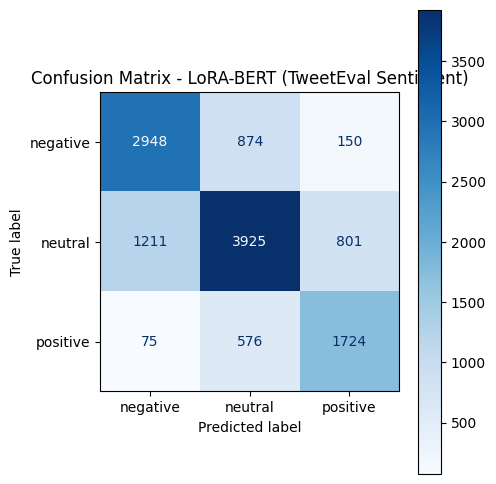

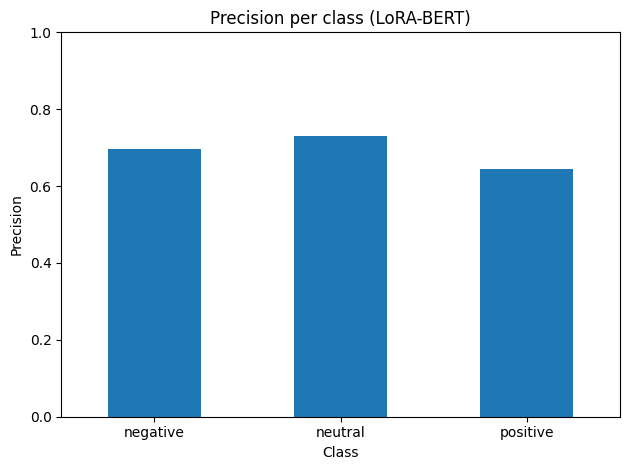

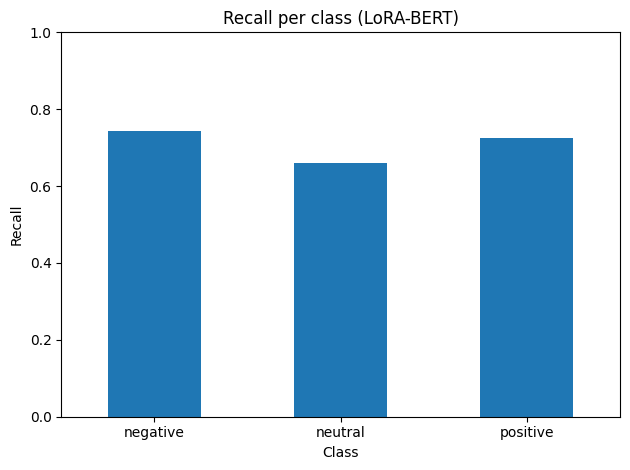

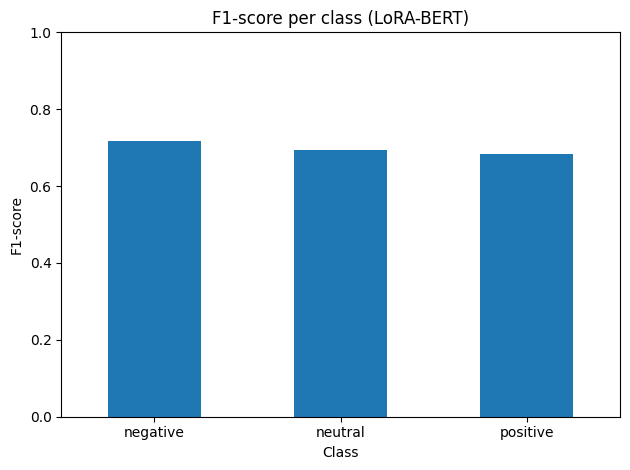

In [ ]:
# Visualization for LoRA-BERT
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# Confusion Matrix (LoRA-BERT)

lora_cm = confusion_matrix(lora_test_labels, lora_test_preds)

lora_disp = ConfusionMatrixDisplay(
    confusion_matrix=lora_cm,
    display_labels=[label_map[i] for i in sorted(label_map.keys())]
)

fig, ax = plt.subplots(figsize=(5, 5))
lora_disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - LoRA-BERT (TweetEval Sentiment)")
plt.tight_layout()
plt.show()
#plt.savefig("confusion_matrix_lora_bert_tweeteval.png", dpi=300)

# Per-class Precision / Recall / F1 (LoRA-BERT)
lora_report_dict = classification_report(
    lora_test_labels,
    lora_test_preds,
    target_names=[label_map[i] for i in sorted(label_map.keys())],
    output_dict=True,
)

lora_cls_names = [label_map[i] for i in sorted(label_map.keys())]
metrics = ["precision", "recall", "f1-score"]

lora_data = {m: [lora_report_dict[cls][m] for cls in lora_cls_names] for m in metrics}
lora_df_metrics = pd.DataFrame(lora_data, index=lora_cls_names)

for m in metrics:
    plt.figure()
    lora_df_metrics[m].plot(kind="bar")
    plt.ylim(0, 1.0)
    plt.title(f"{m.capitalize()} per class (LoRA-BERT)")
    plt.xlabel("Class")
    plt.ylabel(m.capitalize())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{m}_per_class_lora_bert.png", dpi=300)


     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0  0.7061   3.350004   1.333801e-04    1.0  1426        NaN            NaN   
1     NaN        NaN            NaN    1.0  1426    0.64265         0.7170   
2  0.6252   3.119009   6.671342e-05    2.0  2852        NaN            NaN   
3     NaN        NaN            NaN    2.0  2852    0.63571         0.7255   
4  0.6007   3.175489   4.675082e-08    3.0  4278        NaN            NaN   

   eval_macro_f1  eval_runtime  eval_samples_per_second  \
0            NaN           NaN                      NaN   
1       0.697974        2.8915                  691.672   
2            NaN           NaN                      NaN   
3       0.699934        2.9200                  684.926   
4            NaN           NaN                      NaN   

   eval_steps_per_second  train_runtime  train_samples_per_second  \
0                    NaN            NaN                       NaN   
1                 11.067            Na

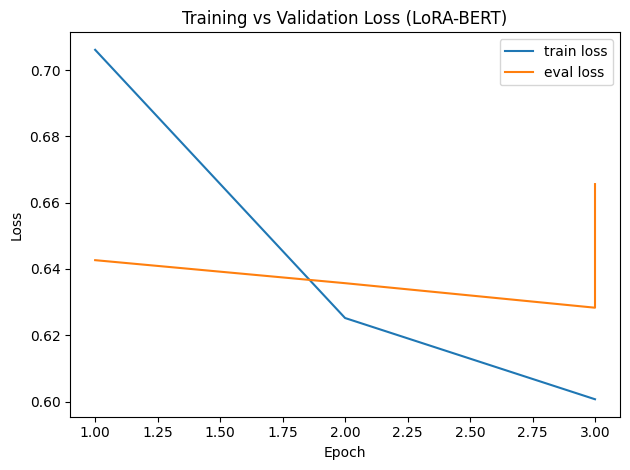

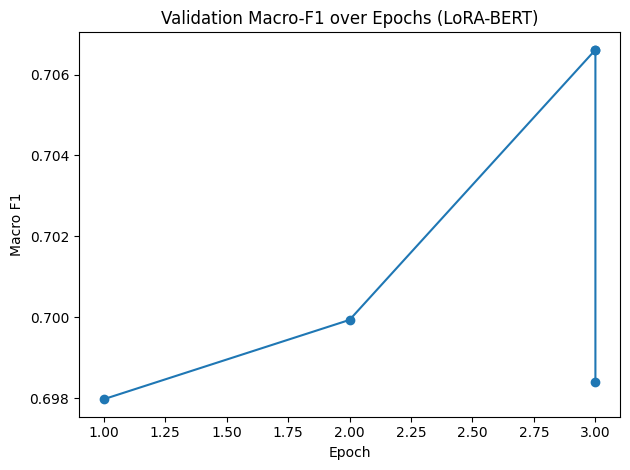

In [ ]:
# Training / Validation Curves for LoRA-BERT
lora_logs = lora_trainer.state.log_history
lora_df_logs = pd.DataFrame(lora_logs)
print(lora_df_logs.head())

# train loss
lora_df_train = lora_df_logs[lora_df_logs["loss"].notnull()]

# eval loss / accuracy / macro_f1
lora_df_eval = lora_df_logs[lora_df_logs["eval_loss"].notnull()]

# Loss
plt.figure()
plt.plot(lora_df_train["epoch"], lora_df_train["loss"], label="train loss")
plt.plot(lora_df_eval["epoch"], lora_df_eval["eval_loss"], label="eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (LoRA-BERT)")
plt.legend()
plt.tight_layout()
plt.show()

# Macro-F1
if "eval_macro_f1" in lora_df_eval.columns:
    plt.figure()
    plt.plot(lora_df_eval["epoch"], lora_df_eval["eval_macro_f1"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title("Validation Macro-F1 over Epochs (LoRA-BERT)")
    plt.tight_layout()
    plt.show()


##RoBERTa-base

In [ ]:
# import os
# os.environ["WANDB_DISABLED"] = "true"

# from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding, TrainingArguments, Trainer

roberta_model_name = "roberta-base"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)

def preprocess_roberta(examples):
    return roberta_tokenizer(
        examples["text"],
        truncation=True,
        padding=False,
        max_length=128,
    )

# re-tokenize dataset for RoBERTa
roberta_encoded_ds = ds.map(preprocess_roberta, batched=True)
roberta_encoded_ds = roberta_encoded_ds.remove_columns(["text"])
roberta_encoded_ds = roberta_encoded_ds.rename_column("label", "labels")
roberta_encoded_ds.set_format("torch")

roberta_data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

# load RoBERTa model
roberta_model = AutoModelForSequenceClassification.from_pretrained(
    roberta_model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

# training arguments
roberta_training_args = TrainingArguments(
    output_dir="./roberta-sentiment",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
    report_to="wandb",
    run_name="roberta-base-run",
)

# Trainer for RoBERTa
roberta_trainer = Trainer(
    model=roberta_model,
    args=roberta_training_args,
    train_dataset=roberta_encoded_ds["train"],
    eval_dataset=roberta_encoded_ds["validation"],
    tokenizer=roberta_tokenizer,
    data_collator=roberta_data_collator,
    compute_metrics=compute_metrics,
)

# train RoBERTa
roberta_train_result = roberta_trainer.train()
print("\nRoBERTa training finished.")

# evaluation
print("\n=== RoBERTa Validation set results ===")
roberta_val_results = roberta_trainer.evaluate(roberta_encoded_ds["validation"])
for k, v in roberta_val_results.items():
    print(f"{k}: {v:.4f}")

print("\n=== RoBERTa Test set results ===")
roberta_test_results = roberta_trainer.evaluate(roberta_encoded_ds["test"])
for k, v in roberta_test_results.items():
    print(f"{k}: {v:.4f}")

# classification report on RoBERTa test set
roberta_pred_output = roberta_trainer.predict(roberta_encoded_ds["test"])
roberta_test_logits = roberta_pred_output.predictions
roberta_test_labels = roberta_pred_output.label_ids
roberta_test_preds = np.argmax(roberta_test_logits, axis=-1)

print("\n=== Classification report on TEST set (RoBERTa-base) ===")
print(
    classification_report(
        roberta_test_labels,
        roberta_test_preds,
        target_names=[label_map[i] for i in sorted(label_map.keys())]
    )
)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-1682872565.py:54: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  roberta_trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.646200,0.587494,0.740500,0.725606
2,0.505000,0.583822,0.750500,0.733659
3,0.407100,0.646278,0.735500,0.720693



RoBERTa training finished.

=== RoBERTa Validation set results ===


eval_loss: 0.5838
eval_accuracy: 0.7505
eval_macro_f1: 0.7337
eval_runtime: 2.4435
eval_samples_per_second: 818.5020
eval_steps_per_second: 13.0960
epoch: 3.0000

=== RoBERTa Test set results ===
eval_loss: 0.7016
eval_accuracy: 0.6989
eval_macro_f1: 0.6976
eval_runtime: 14.4468
eval_samples_per_second: 850.2930
eval_steps_per_second: 13.2900
epoch: 3.0000

=== Classification report on TEST set (RoBERTa-base) ===
              precision    recall  f1-score   support

    negative       0.75      0.68      0.71      3972
     neutral       0.73      0.67      0.70      5937
    positive       0.60      0.80      0.68      2375

    accuracy                           0.70     12284
   macro avg       0.69      0.72      0.70     12284
weighted avg       0.71      0.70      0.70     12284



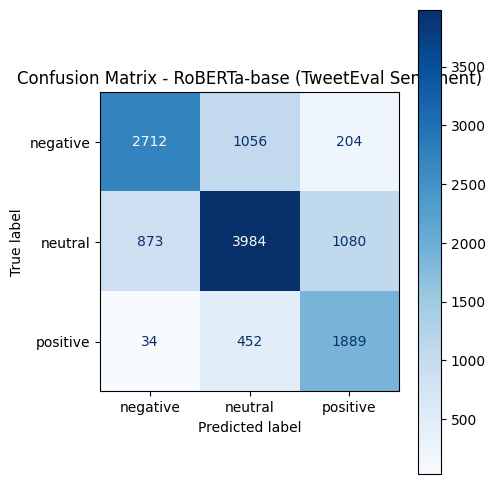

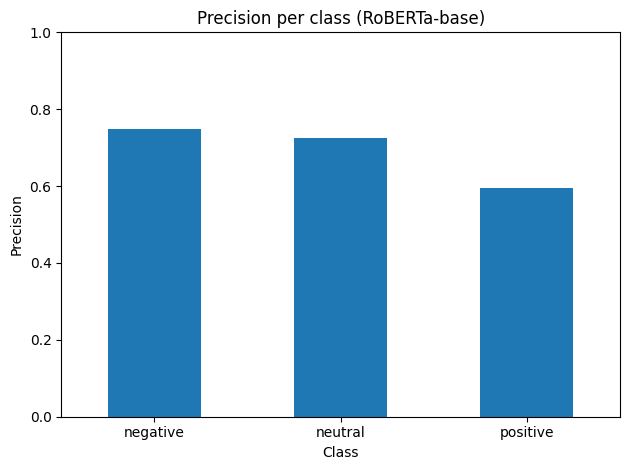

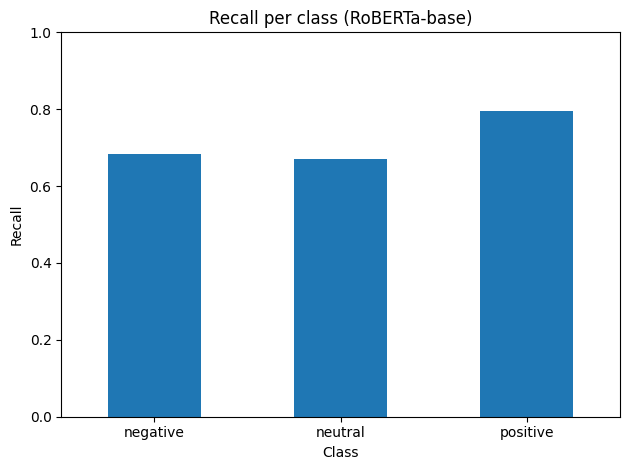

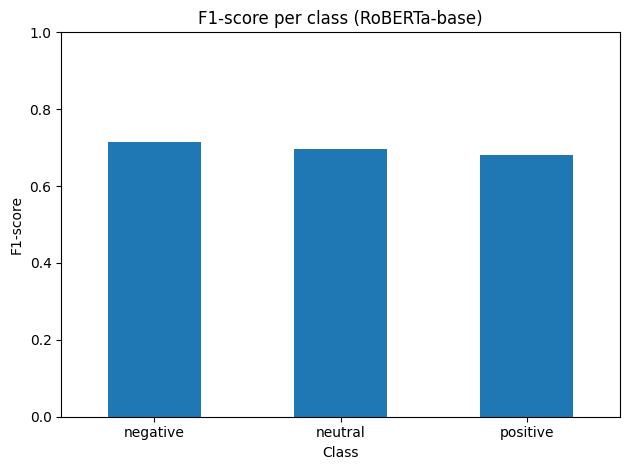

In [ ]:
# Visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

# Confusion Matrix (RoBERTa-base)
roberta_cm = confusion_matrix(roberta_test_labels, roberta_test_preds)

roberta_disp = ConfusionMatrixDisplay(
    confusion_matrix=roberta_cm,
    display_labels=[label_map[i] for i in sorted(label_map.keys())]
)

fig, ax = plt.subplots(figsize=(5, 5))
roberta_disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - RoBERTa-base (TweetEval Sentiment)")
plt.tight_layout()
plt.show()
# plt.savefig("confusion_matrix_roberta_base.png", dpi=300)

# Per-class Precision / Recall / F1 (RoBERTa-base)
roberta_report_dict = classification_report(
    roberta_test_labels,
    roberta_test_preds,
    target_names=[label_map[i] for i in sorted(label_map.keys())],
    output_dict=True,
)

roberta_cls_names = [label_map[i] for i in sorted(label_map.keys())]
metrics = ["precision", "recall", "f1-score"]

roberta_data = {
    m: [roberta_report_dict[cls][m] for cls in roberta_cls_names]
    for m in metrics
}
roberta_df_metrics = pd.DataFrame(roberta_data, index=roberta_cls_names)

for m in metrics:
    plt.figure()
    roberta_df_metrics[m].plot(kind="bar")
    plt.ylim(0, 1.0)
    plt.title(f"{m.capitalize()} per class (RoBERTa-base)")
    plt.xlabel("Class")
    plt.ylabel(m.capitalize())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{m}_per_class_roberta_base.png", dpi=300)


     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0  0.6462  12.165630   1.333801e-05    1.0  1426        NaN            NaN   
1     NaN        NaN            NaN    1.0  1426   0.587494         0.7405   
2  0.5050  11.892793   6.671342e-06    2.0  2852        NaN            NaN   
3     NaN        NaN            NaN    2.0  2852   0.583822         0.7505   
4  0.4071  11.558393   4.675082e-09    3.0  4278        NaN            NaN   

   eval_macro_f1  eval_runtime  eval_samples_per_second  \
0            NaN           NaN                      NaN   
1       0.725606        2.4608                  812.747   
2            NaN           NaN                      NaN   
3       0.733659        2.4671                  810.662   
4            NaN           NaN                      NaN   

   eval_steps_per_second  train_runtime  train_samples_per_second  \
0                    NaN            NaN                       NaN   
1                 13.004            Na

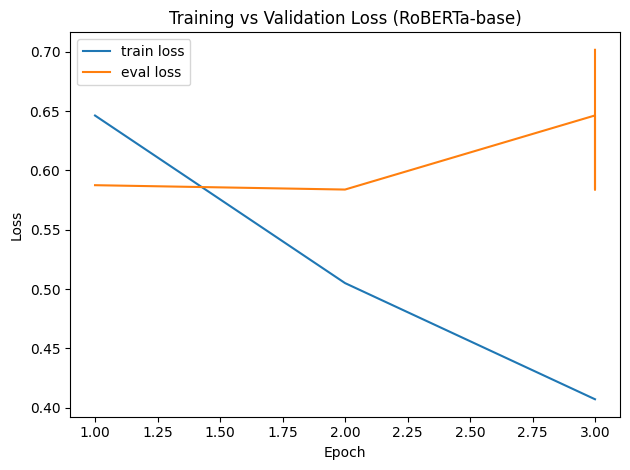

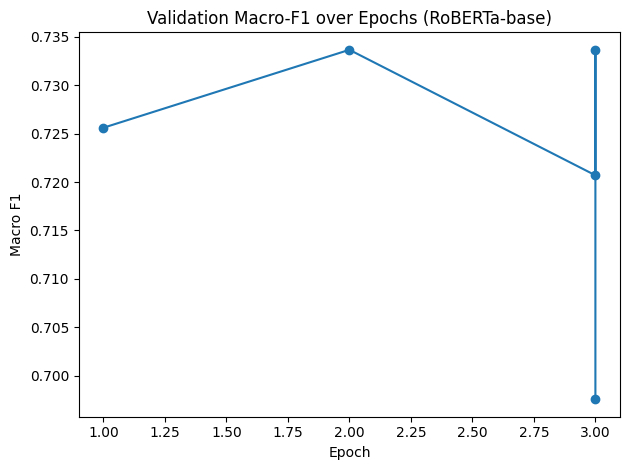

In [ ]:
#  RoBERTa Training / Validation Curves
roberta_logs = roberta_trainer.state.log_history
roberta_df_logs = pd.DataFrame(roberta_logs)
print(roberta_df_logs.head())

# train loss
roberta_df_train = roberta_df_logs[roberta_df_logs["loss"].notnull()]

# eval_loss
roberta_df_eval = roberta_df_logs[roberta_df_logs["eval_loss"].notnull()]

# Train vs Eval Loss
plt.figure()
plt.plot(roberta_df_train["epoch"], roberta_df_train["loss"], label="train loss")
plt.plot(roberta_df_eval["epoch"], roberta_df_eval["eval_loss"], label="eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (RoBERTa-base)")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("roberta_train_eval_loss.png", dpi=300)

# Validation Macro-F1 over Epochs (macro_f1）
if "eval_macro_f1" in roberta_df_eval.columns:
    plt.figure()
    plt.plot(roberta_df_eval["epoch"], roberta_df_eval["eval_macro_f1"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title("Validation Macro-F1 over Epochs (RoBERTa-base)")
    plt.tight_layout()
    plt.show()
    # plt.savefig("roberta_eval_macro_f1.png", dpi=300)


## RoBERTa-LORA

In [ ]:
# import os
# os.environ["WANDB_DISABLED"] = "true"

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)

from peft import LoraConfig, get_peft_model, TaskType
from sklearn.metrics import classification_report
import numpy as np


roberta_model_name = "roberta-base"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name)

def preprocess_roberta(examples):
    return roberta_tokenizer(
        examples["text"],
        truncation=True,
        padding=False,
        max_length=128,
    )

# Re-tokenize dataset for RoBERTa
roberta_encoded_ds = ds.map(preprocess_roberta, batched=True)
roberta_encoded_ds = roberta_encoded_ds.remove_columns(["text"])
roberta_encoded_ds = roberta_encoded_ds.rename_column("label", "labels")
roberta_encoded_ds.set_format("torch")

roberta_data_collator = DataCollatorWithPadding(tokenizer=roberta_tokenizer)

# Load RoBERTa base model
roberta_model = AutoModelForSequenceClassification.from_pretrained(
    roberta_model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

#  Configure and apply LoRA
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "value"],
)

roberta_model = get_peft_model(roberta_model, lora_config)
roberta_model.print_trainable_parameters()

#Training arguments
roberta_training_args = TrainingArguments(
    output_dir="./roberta-sentiment-lora",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    learning_rate=1e-4,
    weight_decay=0.01,
    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
    report_to="wandb",
    run_name="roberta-lora-run",
)

# Trainer
roberta_trainer = Trainer(
    model=roberta_model,
    args=roberta_training_args,
    train_dataset=roberta_encoded_ds["train"],
    eval_dataset=roberta_encoded_ds["validation"],
    tokenizer=roberta_tokenizer,
    data_collator=roberta_data_collator,
    compute_metrics=compute_metrics,
)

# Train RoBERTa + LoRA
roberta_train_result = roberta_trainer.train()
print("\nRoBERTa + LoRA training finished.")

# Evaluation
print("\n=== RoBERTa + LoRA Validation set results ===")
roberta_val_results = roberta_trainer.evaluate(roberta_encoded_ds["validation"])
for k, v in roberta_val_results.items():
    if isinstance(v, (int, float, np.floating)):
        print(f"{k}: {v:.4f}")

print("\n=== RoBERTa + LoRA Test set results ===")
roberta_test_results = roberta_trainer.evaluate(roberta_encoded_ds["test"])
for k, v in roberta_test_results.items():
    if isinstance(v, (int, float, np.floating)):
        print(f"{k}: {v:.4f}")

# Classification report on test set
roberta_pred_output = roberta_trainer.predict(roberta_encoded_ds["test"])
roberta_test_logits = roberta_pred_output.predictions
roberta_test_labels = roberta_pred_output.label_ids
roberta_test_preds = np.argmax(roberta_test_logits, axis=-1)

print("\n=== Classification report on TEST set (RoBERTa-base + LoRA) ===")
print(
    classification_report(
        roberta_test_labels,
        roberta_test_preds,
        target_names=[label_map[i] for i in sorted(label_map.keys())]
    )
)


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2200300864.py:78: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  roberta_trainer = Trainer(


trainable params: 887,811 || all params: 125,535,750 || trainable%: 0.7072


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.683000,0.616878,0.726500,0.705396
2,0.613700,0.611675,0.738500,0.718507
3,0.595800,0.608275,0.742500,0.730002



RoBERTa + LoRA training finished.

=== RoBERTa + LoRA Validation set results ===


eval_loss: 0.6083
eval_accuracy: 0.7425
eval_macro_f1: 0.7300
eval_runtime: 2.5205
eval_samples_per_second: 793.5020
eval_steps_per_second: 12.6960
epoch: 3.0000

=== RoBERTa + LoRA Test set results ===
eval_loss: 0.6432
eval_accuracy: 0.7061
eval_macro_f1: 0.7068
eval_runtime: 14.9014
eval_samples_per_second: 824.3550
eval_steps_per_second: 12.8850
epoch: 3.0000

=== Classification report on TEST set (RoBERTa-base + LoRA) ===
              precision    recall  f1-score   support

    negative       0.71      0.76      0.73      3972
     neutral       0.74      0.64      0.69      5937
    positive       0.64      0.77      0.70      2375

    accuracy                           0.71     12284
   macro avg       0.70      0.72      0.71     12284
weighted avg       0.71      0.71      0.71     12284



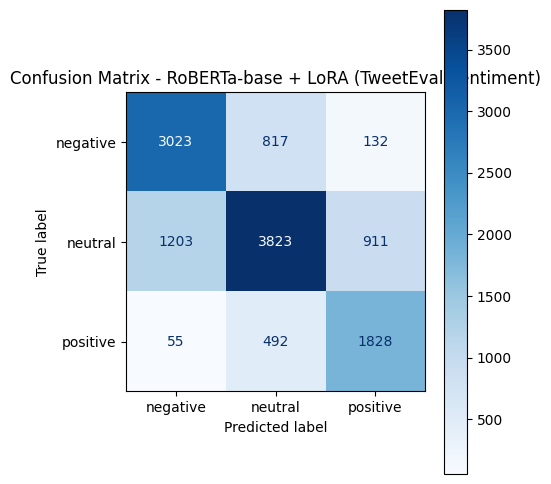

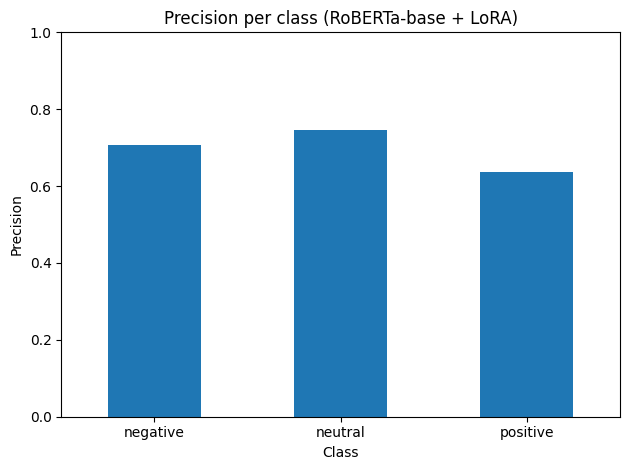

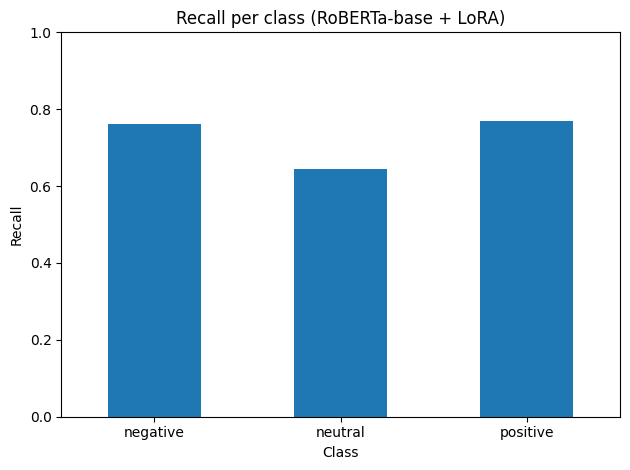

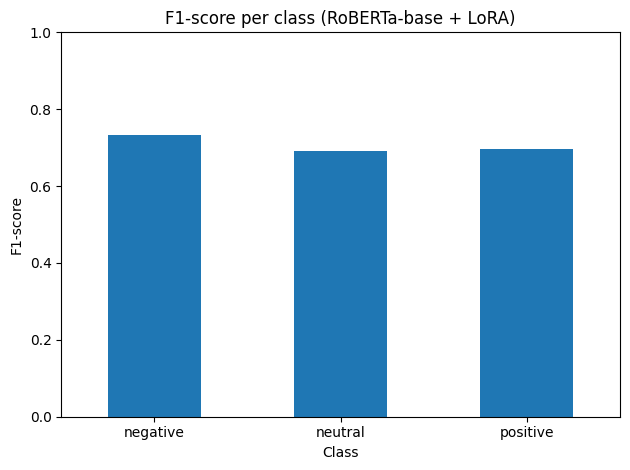

In [ ]:
# Visualization for RoBERTa + LoRA
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import pandas as pd

# Confusion Matrix (RoBERTa + LoRA)
roberta_cm = confusion_matrix(roberta_test_labels, roberta_test_preds)

roberta_disp = ConfusionMatrixDisplay(
    confusion_matrix=roberta_cm,
    display_labels=[label_map[i] for i in sorted(label_map.keys())]
)

fig, ax = plt.subplots(figsize=(5, 5))
roberta_disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - RoBERTa-base + LoRA (TweetEval Sentiment)")
plt.tight_layout()
plt.show()
# plt.savefig("confusion_matrix_roberta_lora.png", dpi=300)

# Per-class Precision / Recall / F1 (RoBERTa + LoRA)
roberta_report_dict = classification_report(
    roberta_test_labels,
    roberta_test_preds,
    target_names=[label_map[i] for i in sorted(label_map.keys())],
    output_dict=True,
)

roberta_cls_names = [label_map[i] for i in sorted(label_map.keys())]
metrics = ["precision", "recall", "f1-score"]

roberta_data = {
    m: [roberta_report_dict[cls][m] for cls in roberta_cls_names]
    for m in metrics
}
roberta_df_metrics = pd.DataFrame(roberta_data, index=roberta_cls_names)

for m in metrics:
    plt.figure()
    roberta_df_metrics[m].plot(kind="bar")
    plt.ylim(0, 1.0)
    plt.title(f"{m.capitalize()} per class (RoBERTa-base + LoRA)")
    plt.xlabel("Class")
    plt.ylabel(m.capitalize())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{m}_per_class_roberta_lora.png", dpi=300)


     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0  0.6830   2.885474   6.669004e-05    1.0  1426        NaN            NaN   
1     NaN        NaN            NaN    1.0  1426   0.616878         0.7265   
2  0.6137   3.069992   3.335671e-05    2.0  2852        NaN            NaN   
3     NaN        NaN            NaN    2.0  2852   0.611675         0.7385   
4  0.5958   4.938820   2.337541e-08    3.0  4278        NaN            NaN   

   eval_macro_f1  eval_runtime  eval_samples_per_second  \
0            NaN           NaN                      NaN   
1       0.705396        2.4906                  803.007   
2            NaN           NaN                      NaN   
3       0.718507        2.5323                  789.794   
4            NaN           NaN                      NaN   

   eval_steps_per_second  train_runtime  train_samples_per_second  \
0                    NaN            NaN                       NaN   
1                 12.848            Na

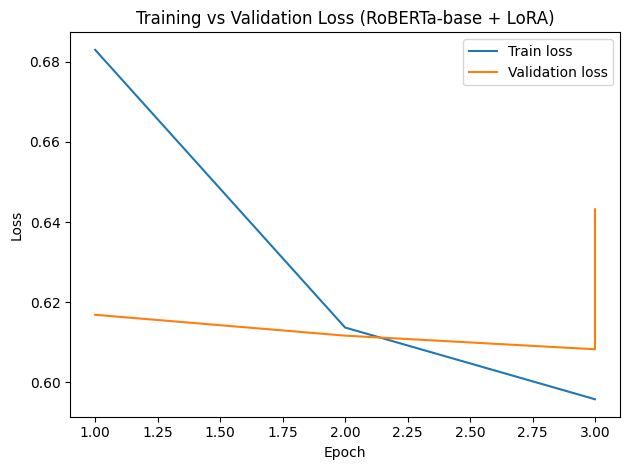

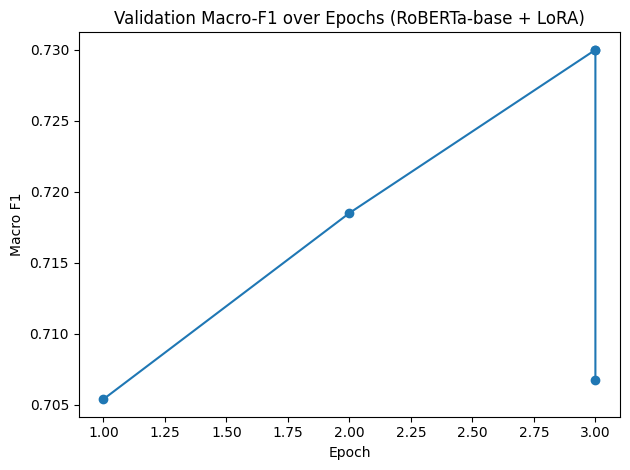

In [ ]:
# RoBERTa + LoRA Training / Validation Curve

# Convert Trainer log history to DataFrame
roberta_logs = roberta_trainer.state.log_history
roberta_df_logs = pd.DataFrame(roberta_logs)
print(roberta_df_logs.head())

# Separate training and evaluation logs
roberta_df_train = roberta_df_logs[roberta_df_logs["loss"].notnull()]
roberta_df_eval = roberta_df_logs[roberta_df_logs["eval_loss"].notnull()]

# Train vs Eval Loss
plt.figure()
plt.plot(roberta_df_train["epoch"], roberta_df_train["loss"], label="Train loss")
plt.plot(roberta_df_eval["epoch"], roberta_df_eval["eval_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (RoBERTa-base + LoRA)")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("roberta_lora_train_eval_loss.png", dpi=300)


# Validation Macro-F1 over Epochs
if "eval_macro_f1" in roberta_df_eval.columns:
    plt.figure()
    plt.plot(roberta_df_eval["epoch"], roberta_df_eval["eval_macro_f1"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title("Validation Macro-F1 over Epochs (RoBERTa-base + LoRA)")
    plt.tight_layout()
    plt.show()
    # plt.savefig("roberta_lora_eval_macro_f1.png", dpi=300)
else:
    print("Column 'eval_macro_f1' not found in evaluation logs.")


## BERTweet

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
import torch
import numpy as np

# ds = load_dataset("cardiffnlp/tweet_eval", "sentiment")

# label_map = {0: "negative", 1: "neutral", 2: "positive"}
# id2label = {i: label_map[i] for i in label_map}
# label2id = {v: k for k, v in label_map.items()}

# tokenizer and encoding
bertweet_model_name = "vinai/bertweet-base"

# BERTweet authors recommend normalization=True for Twitter text
bertweet_tokenizer = AutoTokenizer.from_pretrained(
    bertweet_model_name,
    normalization=True
)

max_length = 128

def tokenize_bertweet(examples):
    return bertweet_tokenizer(
        examples["text"],
        truncation=True,
        padding=False,
        max_length=max_length,
    )

bertweet_encoded_ds = ds.map(tokenize_bertweet, batched=True)
bertweet_encoded_ds = bertweet_encoded_ds.remove_columns(["text"])
bertweet_encoded_ds = bertweet_encoded_ds.rename_column("label", "labels")
bertweet_encoded_ds.set_format("torch")

bertweet_data_collator = DataCollatorWithPadding(tokenizer=bertweet_tokenizer)

# model
bertweet_model = AutoModelForSequenceClassification.from_pretrained(
    bertweet_model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)


# training arguments
bertweet_training_args = TrainingArguments(
    output_dir="./bertweet-sentiment",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    learning_rate=3e-5,
    weight_decay=0.01,

    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
)


# trainer
bertweet_trainer = Trainer(
    model=bertweet_model,
    args=bertweet_training_args,
    train_dataset=bertweet_encoded_ds["train"],
    eval_dataset=bertweet_encoded_ds["validation"],
    tokenizer=bertweet_tokenizer,
    data_collator=bertweet_data_collator,
    compute_metrics=compute_metrics,
)

# train
bertweet_train_result = bertweet_trainer.train()
print("\nBERTweet training finished.")

# evaluation
print("\n=== BERTweet Validation set results ===")
bertweet_val_results = bertweet_trainer.evaluate(bertweet_encoded_ds["validation"])
for k, v in bertweet_val_results.items():
    print(f"{k}: {v:.4f}")

print("\n=== BERTweet Test set results ===")
bertweet_test_results = bertweet_trainer.evaluate(bertweet_encoded_ds["test"])
for k, v in bertweet_test_results.items():
    print(f"{k}: {v:.4f}")

config.json:   0%|          | 0.00/558 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Parameter 'function'=<function tokenize_bertweet at 0x7fb8fbf4c180> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-701041485.py:77: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  bertweet_trainer = Trainer(


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.620000,0.594884,0.733000,0.721020
2,0.451100,0.587949,0.759000,0.744684
3,0.321200,0.680432,0.755500,0.742226



BERTweet training finished.

=== BERTweet Validation set results ===


eval_loss: 0.5879
eval_accuracy: 0.7590
eval_macro_f1: 0.7447
eval_runtime: 2.3916
eval_samples_per_second: 836.2690
eval_steps_per_second: 13.3800
epoch: 3.0000

=== BERTweet Test set results ===
eval_loss: 0.6573
eval_accuracy: 0.7226
eval_macro_f1: 0.7205
eval_runtime: 12.1929
eval_samples_per_second: 1007.4750
eval_steps_per_second: 15.7470
epoch: 3.0000



=== Classification report on TEST set (BERTweet-base) ===
              precision    recall  f1-score   support

    negative       0.75      0.71      0.73      3972
     neutral       0.72      0.73      0.72      5937
    positive       0.68      0.73      0.71      2375

    accuracy                           0.72     12284
   macro avg       0.72      0.72      0.72     12284
weighted avg       0.72      0.72      0.72     12284



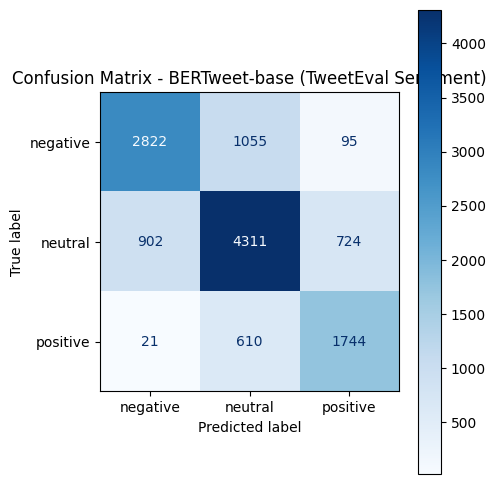

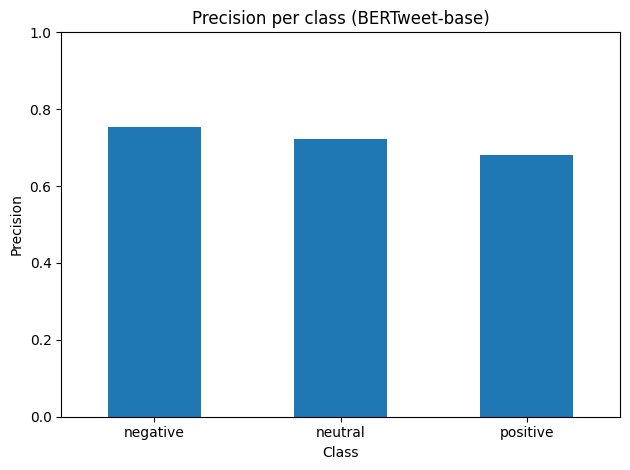

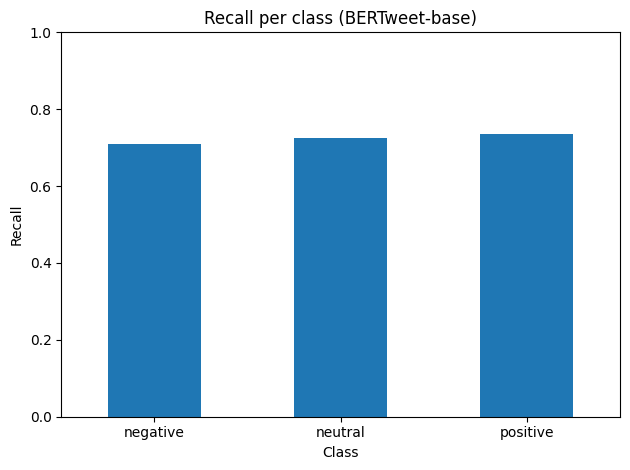

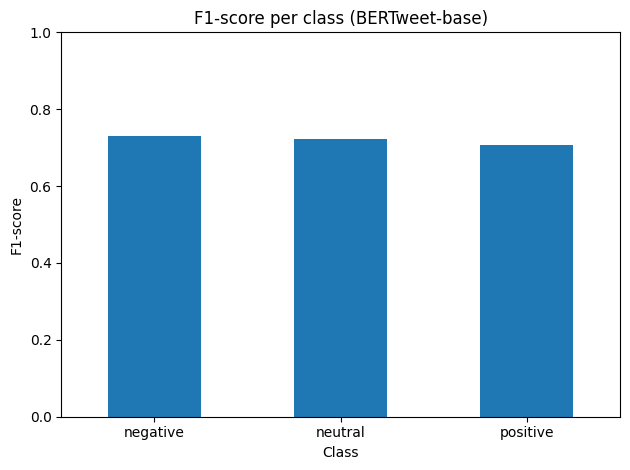

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

# Classification report on TEST set
bertweet_pred_output = bertweet_trainer.predict(bertweet_encoded_ds["test"])
bertweet_test_logits = bertweet_pred_output.predictions
bertweet_test_labels = bertweet_pred_output.label_ids
bertweet_test_preds = np.argmax(bertweet_test_logits, axis=-1)

print("\n=== Classification report on TEST set (BERTweet-base) ===")
print(
    classification_report(
        bertweet_test_labels,
        bertweet_test_preds,
        target_names=[label_map[i] for i in sorted(label_map.keys())]
    )
)

# Confusion Matrix
bertweet_cm = confusion_matrix(bertweet_test_labels, bertweet_test_preds)

bertweet_disp = ConfusionMatrixDisplay(
    confusion_matrix=bertweet_cm,
    display_labels=[label_map[i] for i in sorted(label_map.keys())]
)

fig, ax = plt.subplots(figsize=(5, 5))
bertweet_disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - BERTweet-base (TweetEval Sentiment)")
plt.tight_layout()
plt.show()
# plt.savefig("confusion_matrix_bertweet_base.png", dpi=300)

# Per-class Precision / Recall / F1
bertweet_report_dict = classification_report(
    bertweet_test_labels,
    bertweet_test_preds,
    target_names=[label_map[i] for i in sorted(label_map.keys())],
    output_dict=True,
)

bertweet_cls_names = [label_map[i] for i in sorted(label_map.keys())]
metrics = ["precision", "recall", "f1-score"]

bertweet_data = {
    m: [bertweet_report_dict[cls][m] for cls in bertweet_cls_names]
    for m in metrics
}
bertweet_df_metrics = pd.DataFrame(bertweet_data, index=bertweet_cls_names)

for m in metrics:
    plt.figure()
    bertweet_df_metrics[m].plot(kind="bar")
    plt.ylim(0, 1.0)
    plt.title(f"{m.capitalize()} per class (BERTweet-base)")
    plt.xlabel("Class")
    plt.ylabel(m.capitalize())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{m}_per_class_bertweet_base.png", dpi=300)


     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0  0.6200   8.055259   2.000701e-05    1.0  1426        NaN            NaN   
1     NaN        NaN            NaN    1.0  1426   0.594884          0.733   
2  0.4511   5.566494   1.000701e-05    2.0  2852        NaN            NaN   
3     NaN        NaN            NaN    2.0  2852   0.587949          0.759   
4  0.3212   7.659184   7.012623e-09    3.0  4278        NaN            NaN   

   eval_macro_f1  eval_runtime  eval_samples_per_second  \
0            NaN           NaN                      NaN   
1       0.721020        2.4077                  830.662   
2            NaN           NaN                      NaN   
3       0.744684        2.4153                  828.069   
4            NaN           NaN                      NaN   

   eval_steps_per_second  train_runtime  train_samples_per_second  \
0                    NaN            NaN                       NaN   
1                 13.291            Na

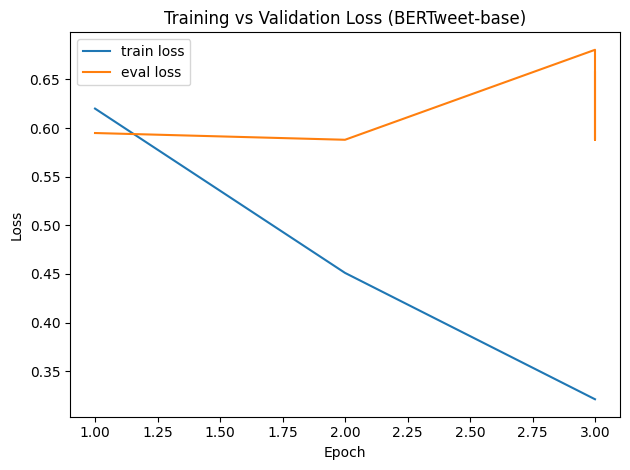

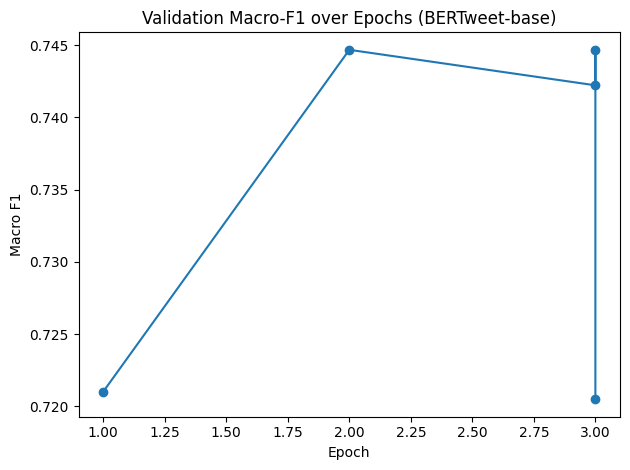

In [ ]:
# BERTweet Training / Validation Curves

bertweet_logs = bertweet_trainer.state.log_history
bertweet_df_logs = pd.DataFrame(bertweet_logs)
print(bertweet_df_logs.head())

# train loss
bertweet_df_train = bertweet_df_logs[bertweet_df_logs["loss"].notnull()]

# eval
bertweet_df_eval = bertweet_df_logs[bertweet_df_logs["eval_loss"].notnull()]

# Train vs Eval Loss
plt.figure()
plt.plot(bertweet_df_train["epoch"], bertweet_df_train["loss"], label="train loss")
plt.plot(bertweet_df_eval["epoch"], bertweet_df_eval["eval_loss"], label="eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (BERTweet-base)")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("bertweet_train_eval_loss.png", dpi=300)

# Validation Macro-F1 over Epochs
if "eval_macro_f1" in bertweet_df_eval.columns:
    plt.figure()
    plt.plot(bertweet_df_eval["epoch"], bertweet_df_eval["eval_macro_f1"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title("Validation Macro-F1 over Epochs (BERTweet-base)")
    plt.tight_layout()
    plt.show()
    # plt.savefig("bertweet_eval_macro_f1.png", dpi=300)


## BERTweet-LoRA

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    DataCollatorWithPadding,
    TrainingArguments,
    Trainer,
)
import torch
import numpy as np
from peft import LoraConfig, get_peft_model, TaskType

# ds = load_dataset("cardiffnlp/tweet_eval", "sentiment")

# label_map = {0: "negative", 1: "neutral", 2: "positive"}
# id2label = {i: label_map[i] for i in label_map}
# label2id = {v: k for k, v in label_map.items()}

# Tokenizer and encoding
bertweet_model_name = "vinai/bertweet-base"

bertweet_tokenizer = AutoTokenizer.from_pretrained(
    bertweet_model_name,
    normalization=True
)

max_length = 128

def tokenize_bertweet(examples):
    return bertweet_tokenizer(
        examples["text"],
        truncation=True,
        padding=False,
        max_length=max_length,
    )

bertweet_encoded_ds = ds.map(tokenize_bertweet, batched=True)
bertweet_encoded_ds = bertweet_encoded_ds.remove_columns(["text"])
bertweet_encoded_ds = bertweet_encoded_ds.rename_column("label", "labels")
bertweet_encoded_ds.set_format("torch")

bertweet_data_collator = DataCollatorWithPadding(tokenizer=bertweet_tokenizer)

bertweet_model = AutoModelForSequenceClassification.from_pretrained(
    bertweet_model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

# LoRA configuration & wrapping
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    bias="none",
    target_modules=["query", "value"],
)

bertweet_model = get_peft_model(bertweet_model, lora_config)
bertweet_model.print_trainable_parameters()


# Training arguments
bertweet_training_args = TrainingArguments(
    output_dir="./bertweet-sentiment-lora",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    learning_rate=1e-4,
    weight_decay=0.01,

    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
)


# Trainer
bertweet_trainer = Trainer(
    model=bertweet_model,
    args=bertweet_training_args,
    train_dataset=bertweet_encoded_ds["train"],
    eval_dataset=bertweet_encoded_ds["validation"],
    tokenizer=bertweet_tokenizer,
    data_collator=bertweet_data_collator,
    compute_metrics=compute_metrics,
)


# Train
bertweet_train_result = bertweet_trainer.train()
print("\nBERTweet + LoRA training finished.")

# Evaluation
print("\n=== BERTweet + LoRA Validation set results ===")
bertweet_val_results = bertweet_trainer.evaluate(bertweet_encoded_ds["validation"])
for k, v in bertweet_val_results.items():
    if isinstance(v, (int, float, np.floating)):
        print(f"{k}: {v:.4f}")

print("\n=== BERTweet + LoRA Test set results ===")
bertweet_test_results = bertweet_trainer.evaluate(bertweet_encoded_ds["test"])
for k, v in bertweet_test_results.items():
    if isinstance(v, (int, float, np.floating)):
        print(f"{k}: {v:.4f}")


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3947106098.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  bertweet_trainer = Trainer(


trainable params: 887,811 || all params: 135,790,086 || trainable%: 0.6538


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.672200,0.605332,0.739000,0.723940
2,0.588000,0.593525,0.740500,0.726674
3,0.570300,0.592063,0.741000,0.727971



BERTweet + LoRA training finished.

=== BERTweet + LoRA Validation set results ===


eval_loss: 0.5921
eval_accuracy: 0.7410
eval_macro_f1: 0.7280
eval_runtime: 2.4692
eval_samples_per_second: 809.9630
eval_steps_per_second: 12.9590
epoch: 3.0000

=== BERTweet + LoRA Test set results ===
eval_loss: 0.6208
eval_accuracy: 0.7136
eval_macro_f1: 0.7137
eval_runtime: 12.5743
eval_samples_per_second: 976.9110
eval_steps_per_second: 15.2690
epoch: 3.0000



=== Classification report on TEST set (BERTweet + LoRA) ===
              precision    recall  f1-score   support

    negative       0.70      0.79      0.74      3972
     neutral       0.75      0.65      0.70      5937
    positive       0.67      0.73      0.70      2375

    accuracy                           0.71     12284
   macro avg       0.71      0.73      0.71     12284
weighted avg       0.72      0.71      0.71     12284



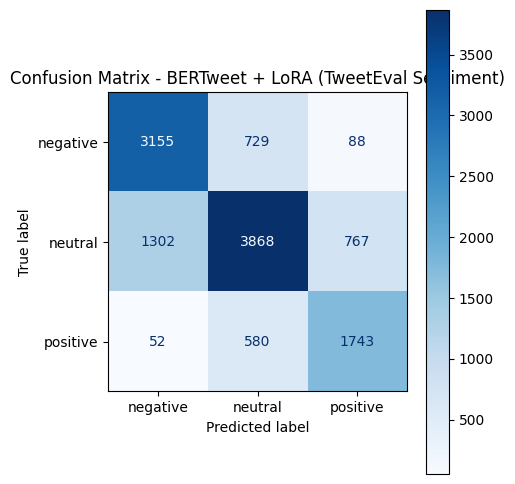

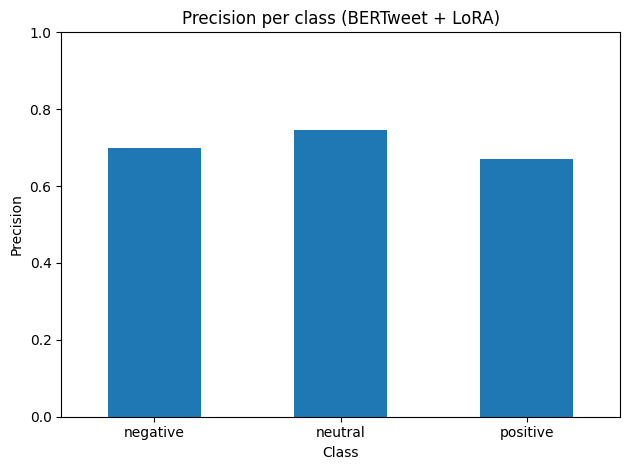

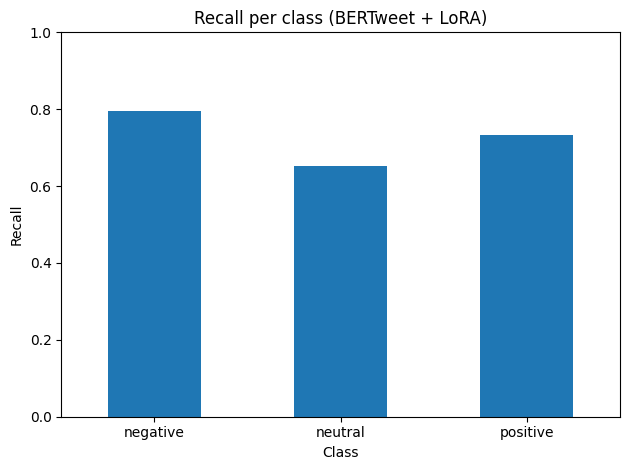

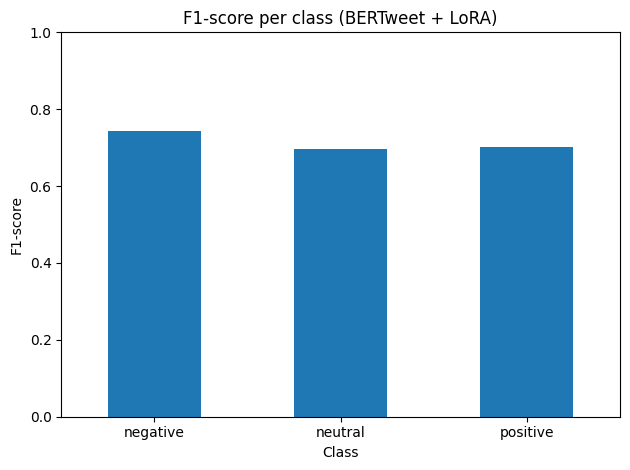

     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0  0.6722   2.963583   6.669004e-05    1.0  1426        NaN            NaN   
1     NaN        NaN            NaN    1.0  1426   0.605332         0.7390   
2  0.5880   2.204762   3.335671e-05    2.0  2852        NaN            NaN   
3     NaN        NaN            NaN    2.0  2852   0.593525         0.7405   
4  0.5703   3.876138   2.337541e-08    3.0  4278        NaN            NaN   

   eval_macro_f1  eval_runtime  eval_samples_per_second  \
0            NaN           NaN                      NaN   
1       0.723940        2.4205                  826.273   
2            NaN           NaN                      NaN   
3       0.726674        2.4813                  806.020   
4            NaN           NaN                      NaN   

   eval_steps_per_second  train_runtime  train_samples_per_second  \
0                    NaN            NaN                       NaN   
1                 13.220            Na

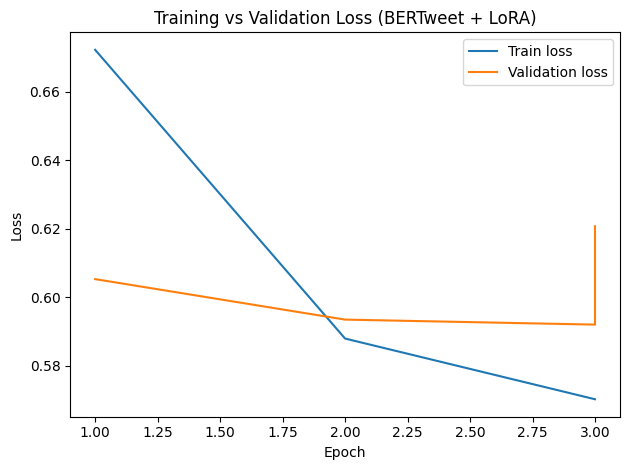

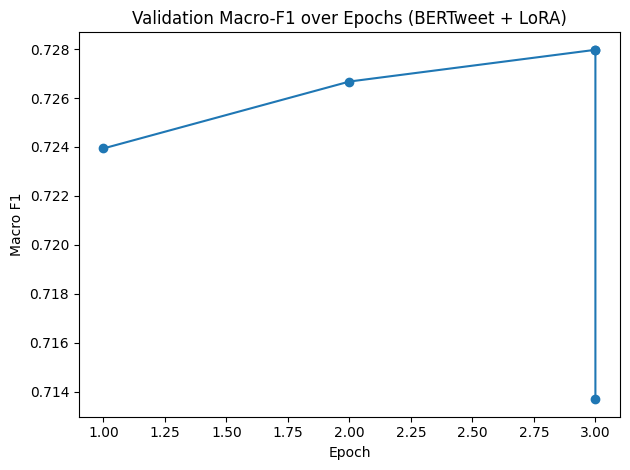

In [ ]:
# Visualization for BERTweet + LoRA
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
import pandas as pd

# Predictions on test set
bertweet_pred_output = bertweet_trainer.predict(bertweet_encoded_ds["test"])
bertweet_test_logits = bertweet_pred_output.predictions
bertweet_test_labels = bertweet_pred_output.label_ids
bertweet_test_preds = np.argmax(bertweet_test_logits, axis=-1)

print("\n=== Classification report on TEST set (BERTweet + LoRA) ===")
print(
    classification_report(
        bertweet_test_labels,
        bertweet_test_preds,
        target_names=[label_map[i] for i in sorted(label_map.keys())]
    )
)

# Confusion Matrix
bertweet_cm = confusion_matrix(bertweet_test_labels, bertweet_test_preds)

bertweet_disp = ConfusionMatrixDisplay(
    confusion_matrix=bertweet_cm,
    display_labels=[label_map[i] for i in sorted(label_map.keys())]
)

fig, ax = plt.subplots(figsize=(5, 5))
bertweet_disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - BERTweet + LoRA (TweetEval Sentiment)")
plt.tight_layout()
plt.show()
# plt.savefig("confusion_matrix_bertweet_lora.png", dpi=300)

#Per-class Precision / Recall / F1
bertweet_report_dict = classification_report(
    bertweet_test_labels,
    bertweet_test_preds,
    target_names=[label_map[i] for i in sorted(label_map.keys())],
    output_dict=True,
)

bertweet_cls_names = [label_map[i] for i in sorted(label_map.keys())]
metrics = ["precision", "recall", "f1-score"]

bertweet_data = {
    m: [bertweet_report_dict[cls][m] for cls in bertweet_cls_names]
    for m in metrics
}
bertweet_df_metrics = pd.DataFrame(bertweet_data, index=bertweet_cls_names)

for m in metrics:
    plt.figure()
    bertweet_df_metrics[m].plot(kind="bar")
    plt.ylim(0, 1.0)
    plt.title(f"{m.capitalize()} per class (BERTweet + LoRA)")
    plt.xlabel("Class")
    plt.ylabel(m.capitalize())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{m}_per_class_bertweet_lora.png", dpi=300)

  #Training / Validation Curves
bertweet_logs = bertweet_trainer.state.log_history
bertweet_df_logs = pd.DataFrame(bertweet_logs)
print(bertweet_df_logs.head())

# Split train / eval logs
bertweet_df_train = bertweet_df_logs[bertweet_df_logs["loss"].notnull()]
bertweet_df_eval = bertweet_df_logs[bertweet_df_logs["eval_loss"].notnull()]

# Train vs Eval Loss
plt.figure()
plt.plot(bertweet_df_train["epoch"], bertweet_df_train["loss"], label="Train loss")
plt.plot(bertweet_df_eval["epoch"], bertweet_df_eval["eval_loss"], label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (BERTweet + LoRA)")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("bertweet_lora_train_eval_loss.png", dpi=300)

# Validation Macro-F1 over epochs
if "eval_macro_f1" in bertweet_df_eval.columns:
    plt.figure()
    plt.plot(bertweet_df_eval["epoch"], bertweet_df_eval["eval_macro_f1"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title("Validation Macro-F1 over Epochs (BERTweet + LoRA)")
    plt.tight_layout()
    plt.show()
    # plt.savefig("bertweet_lora_eval_macro_f1.png", dpi=300)
else:
    print("Column 'eval_macro_f1' not found in evaluation logs.")



## BERTweet + class weights + label smoothing

In [ ]:
# BERTweet + class weights + label smoothing
from collections import Counter
import torch
import torch.nn as nn
from transformers import Trainer

# compute class weights from original ds
train_labels = ds["train"]["label"]
label_counts = Counter(train_labels)
print("Label counts:", label_counts)

num_labels = len(label_map)

total = sum(label_counts.values())
class_weights = torch.tensor(
    [total / label_counts[i] for i in range(num_labels)],
    dtype=torch.float,
)

# normalize so that mean weight is 1
class_weights = class_weights / class_weights.mean()
print("class_weights:", class_weights)


class WeightedSmoothedTrainer(Trainer):
    def __init__(self, class_weights=None, label_smoothing=0.05, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights
        self.label_smoothing = label_smoothing

    # num_items_in_batch kept for compatibility with different HF versions
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs["labels"]
        model_inputs = {k: v for k, v in inputs.items() if k != "labels"}

        outputs = model(**model_inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            weights = self.class_weights.to(logits.device)
            loss_fct = nn.CrossEntropyLoss(
                weight=weights,
                label_smoothing=self.label_smoothing,
            )
        else:
            loss_fct = nn.CrossEntropyLoss(
                label_smoothing=self.label_smoothing,
            )

        loss = loss_fct(
            logits.view(-1, model.config.num_labels),
            labels.view(-1),
        )

        return (loss, outputs) if return_outputs else loss


# weighted BERTweet model
bertweet_ws_model = AutoModelForSequenceClassification.from_pretrained(
    bertweet_model_name,
    num_labels=3,
    id2label=id2label,
    label2id=label2id,
)

bertweet_ws_training_args = TrainingArguments(
    output_dir="./bertweet-sentiment-ws",
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    learning_rate=2e-5,
    weight_decay=0.01,

    eval_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_macro_f1",
    greater_is_better=True,
)


bertweet_ws_trainer = WeightedSmoothedTrainer(
    model=bertweet_ws_model,
    args=bertweet_ws_training_args,
    train_dataset=bertweet_encoded_ds["train"],
    eval_dataset=bertweet_encoded_ds["validation"],
    tokenizer=bertweet_tokenizer,
    data_collator=bertweet_data_collator,
    compute_metrics=compute_metrics,
    class_weights=class_weights,
    label_smoothing=0.05,
)

# train
bertweet_ws_trainer.train()
print("\nWeighted + smoothed BERTweet training finished.")

# evaluation
bertweet_ws_val_results = bertweet_ws_trainer.evaluate(bertweet_encoded_ds["validation"])
print("\n=== Val metrics (BERTweet + weights + label smoothing) ===")
for k, v in bertweet_ws_val_results.items():
    print(f"{k}: {v:.4f}")

bertweet_ws_test_results = bertweet_ws_trainer.evaluate(bertweet_encoded_ds["test"])
print("\n=== Test metrics (BERTweet + weights + label smoothing) ===")
for k, v in bertweet_ws_test_results.items():
    print(f"{k}: {v:.4f}")

Label counts: Counter({1: 20673, 2: 17849, 0: 7093})
class_weights: tensor([1.7236, 0.5914, 0.6850])


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/tmp/ipython-input-3582825654.py:27: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedSmoothedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(**kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1
1,0.717800,0.677457,0.705000,0.696407
2,0.582300,0.680140,0.752500,0.740046
3,0.498300,0.718387,0.743000,0.728612



Weighted + smoothed BERTweet training finished.



=== Val metrics (BERTweet + weights + label smoothing) ===
eval_loss: 0.6801
eval_accuracy: 0.7525
eval_macro_f1: 0.7400
eval_runtime: 2.4019
eval_samples_per_second: 832.6850
eval_steps_per_second: 13.3230
epoch: 3.0000

=== Test metrics (BERTweet + weights + label smoothing) ===
eval_loss: 0.6274
eval_accuracy: 0.7135
eval_macro_f1: 0.7148
eval_runtime: 12.2443
eval_samples_per_second: 1003.2450
eval_steps_per_second: 15.6810
epoch: 3.0000



=== Classification report on TEST set (BERTweet + weights + smoothing) ===
              precision    recall  f1-score   support

    negative       0.68      0.84      0.75      3972
     neutral       0.78      0.61      0.68      5937
    positive       0.66      0.76      0.71      2375

    accuracy                           0.71     12284
   macro avg       0.71      0.74      0.71     12284
weighted avg       0.72      0.71      0.71     12284



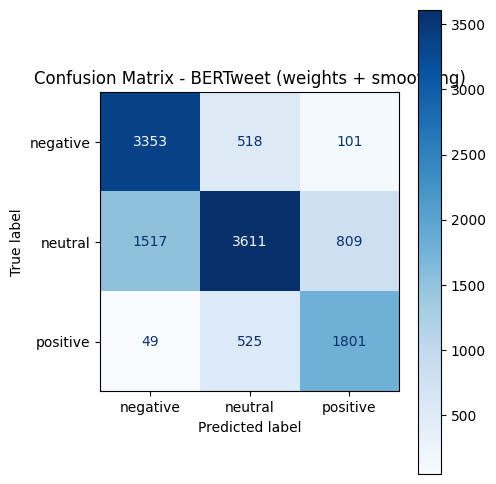

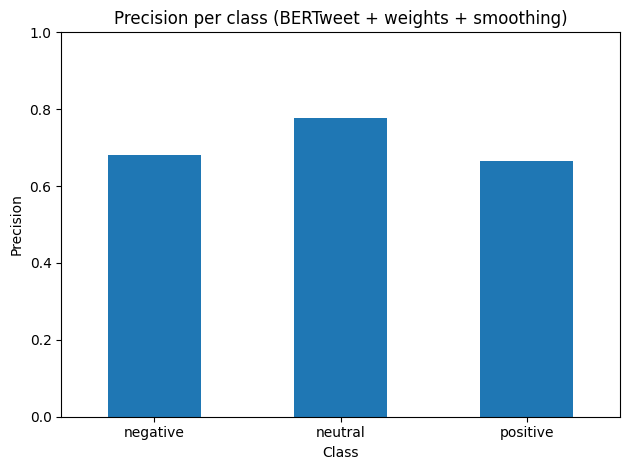

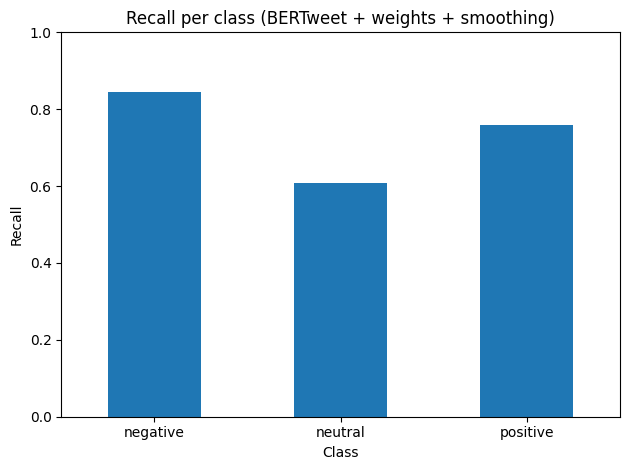

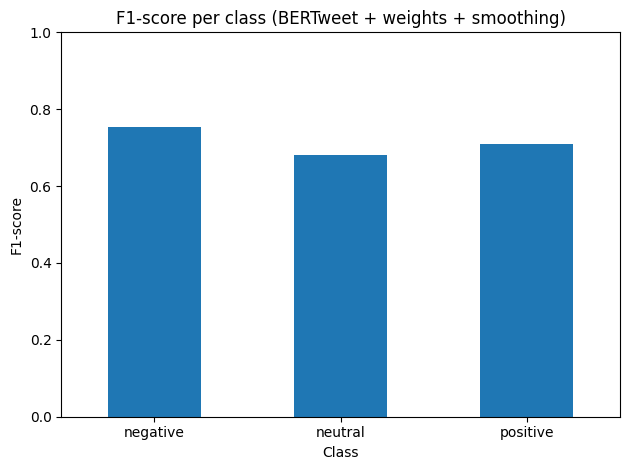


[DEBUG] First few log rows for BERTweet + weights + smoothing:
     loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0  0.7178   7.875185   1.333801e-05    1.0  1426        NaN            NaN   
1     NaN        NaN            NaN    1.0  1426   0.677457         0.7050   
2  0.5823   5.519830   6.671342e-06    2.0  2852        NaN            NaN   
3     NaN        NaN            NaN    2.0  2852   0.680140         0.7525   
4  0.4983   7.807717   4.675082e-09    3.0  4278        NaN            NaN   

   eval_macro_f1  eval_runtime  eval_samples_per_second  \
0            NaN           NaN                      NaN   
1       0.696407        2.4088                  830.283   
2            NaN           NaN                      NaN   
3       0.740046        2.4049                  831.624   
4            NaN           NaN                      NaN   

   eval_steps_per_second  train_runtime  train_samples_per_second  \
0                    NaN            NaN    

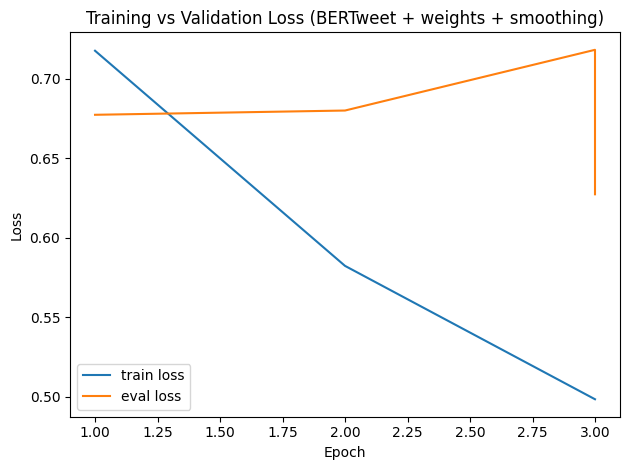

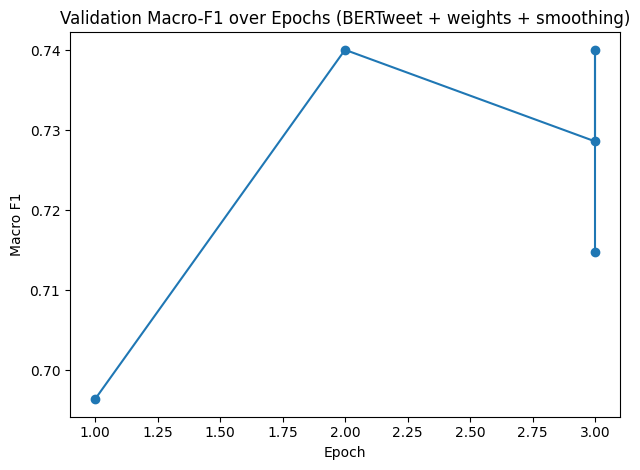

In [ ]:
# Visualization: BERTweet + class weights + label smoothing

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Classification report on TEST set

bertweet_ws_pred_output = bertweet_ws_trainer.predict(bertweet_encoded_ds["test"])
bertweet_ws_test_logits = bertweet_ws_pred_output.predictions
bertweet_ws_test_labels = bertweet_ws_pred_output.label_ids
bertweet_ws_test_preds = np.argmax(bertweet_ws_test_logits, axis=-1)

print("\n=== Classification report on TEST set (BERTweet + weights + smoothing) ===")
print(
    classification_report(
        bertweet_ws_test_labels,
        bertweet_ws_test_preds,
        target_names=[label_map[i] for i in sorted(label_map.keys())]
    )
)

#  Confusion Matrix

bertweet_ws_cm = confusion_matrix(bertweet_ws_test_labels, bertweet_ws_test_preds)

ws_disp = ConfusionMatrixDisplay(
    confusion_matrix=bertweet_ws_cm,
    display_labels=[label_map[i] for i in sorted(label_map.keys())]
)

fig, ax = plt.subplots(figsize=(5, 5))
ws_disp.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - BERTweet (weights + smoothing)")
plt.tight_layout()
plt.show()
# plt.savefig("cm_bertweet_weights_smoothing.png", dpi=300)

# Per-class Precision / Recall / F1
bertweet_ws_report_dict = classification_report(
    bertweet_ws_test_labels,
    bertweet_ws_test_preds,
    target_names=[label_map[i] for i in sorted(label_map.keys())],
    output_dict=True,
)

ws_cls_names = [label_map[i] for i in sorted(label_map.keys())]
metrics = ["precision", "recall", "f1-score"]

ws_data = {
    m: [bertweet_ws_report_dict[cls][m] for cls in ws_cls_names]
    for m in metrics
}
ws_df_metrics = pd.DataFrame(ws_data, index=ws_cls_names)

for m in metrics:
    plt.figure()
    ws_df_metrics[m].plot(kind="bar")
    plt.ylim(0, 1.0)
    plt.title(f"{m.capitalize()} per class (BERTweet + weights + smoothing)")
    plt.xlabel("Class")
    plt.ylabel(m.capitalize())
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{m}_per_class_bertweet_ws.png", dpi=300)

# Train / Eval Loss & Macro-F1 curves
ws_logs = bertweet_ws_trainer.state.log_history
ws_df_logs = pd.DataFrame(ws_logs)
print("\n[DEBUG] First few log rows for BERTweet + weights + smoothing:")
print(ws_df_logs.head())

# loss（'loss'）
ws_df_train = ws_df_logs[ws_df_logs["loss"].notnull()]

# 'eval_loss'
ws_df_eval = ws_df_logs[ws_df_logs["eval_loss"].notnull()]

# Loss
plt.figure()
plt.plot(ws_df_train["epoch"], ws_df_train["loss"], label="train loss")
plt.plot(ws_df_eval["epoch"], ws_df_eval["eval_loss"], label="eval loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss (BERTweet + weights + smoothing)")
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("bertweet_ws_train_eval_loss.png", dpi=300)

# Macro-F1
if "eval_macro_f1" in ws_df_eval.columns:
    plt.figure()
    plt.plot(ws_df_eval["epoch"], ws_df_eval["eval_macro_f1"], marker="o")
    plt.xlabel("Epoch")
    plt.ylabel("Macro F1")
    plt.title("Validation Macro-F1 over Epochs (BERTweet + weights + smoothing)")
    plt.tight_layout()
    plt.show()
    # plt.savefig("bertweet_ws_eval_macro_f1.png", dpi=300)
